# Landlides!

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split

In [2]:
#this comes in handy throughout
def print_results(results):
    print("Training set score: {:.2f}".format(results[0]))
    print("Test set score: {:.2f}".format(results[1]))

## Pre-Processing the Data

In [3]:
df = pd.read_csv('GLC.csv')
df

,landslide_category,landslide_size,fatality_count,event_date,landslide_trigger,landslide_setting,country_name,country_code,admin_division_population,longitude,latitude
0,landslide,large,11.0,8/1/2008 0:00,rain,mine,China,CN,0.0,107.450000,32.562500
1,mudslide,small,0.0,1/2/2009 2:00,downpour,unknown,United States,US,36619.0,-122.663000,45.420000
2,landslide,large,10.0,1/19/2007 0:00,downpour,unknown,Peru,PE,14708.0,-75.358700,-11.129500
3,landslide,medium,1.0,7/31/2009 0:00,monsoon,unknown,Nepal,NP,20908.0,81.708000,28.837800
4,landslide,medium,0.0,10/16/2010 12:00,tropical_cyclone,unknown,Philippines,PH,798634.0,123.897800,10.333600
...,...,...,...,...,...,...,...,...,...,...,...
11028,landslide,medium,27.0,4/1/2017 13:34,rain,natural_slope,NaN,NaN,NaN,111.679944,-7.853409
11029,landslide,small,2.0,3/25/2017 17:32,other,natural_slope,NaN,NaN,NaN,75.680611,33.403080
11030,landslide,small,1.0,12/15/2016 5:00,unknown,urban,NaN,NaN,NaN,91.772042,26.181606
11031,translational_slide,large,24.0,4/29/2017 19:03,downpour,natural_slope,NaN,NaN,NaN,73.472379,40.886395


One of the first things to consider is how to process NaN values. In categorical data, we replaced these with a new category "not_provided", as this seemed most consistent with the values "unknown" and "other" already being part of the data. We will process NaN in numeric data later.

In [4]:
df['landslide_size'] = df['landslide_size'].fillna('not_provided')
df['landslide_category'] = df['landslide_category'].fillna('not_provided')
df['landslide_trigger'] = df['landslide_trigger'].fillna('not_provided')
df['landslide_setting'] = df['landslide_setting'].fillna('not_provided')

In [5]:
print(df['landslide_category'].value_counts())

landslide_category
landslide              7648
mudslide               2100
rock_fall               671
complex                 232
debris_flow             194
other                    68
unknown                  38
riverbank_collapse       37
snow_avalanche           15
translational_slide       9
lahar                     7
earth_flow                7
creep                     5
not_provided              1
topple                    1
Name: count, dtype: int64


We then also needed to change all our string values to useful numbers. Many of these are not naturally on a scale, but "landslide_size" is. Therefore we manually ordered these from small to catastrophic.

In [6]:
landslide_size_code_transform = {
    'unknown': 0, #Making 'unknown' into 0 because it feels more likely to be small than catastrophic
    'not_provided': 6, # there is only one of these, and it ends up being deleted when we remove some rows later on
    'small': 1,
    'medium': 2, 
    'large': 3, 
    'very_large': 4,
    'catastrophic': 5
}

Now we apply the code transformation.

In [7]:
#Adds numeric codes for each string feature.
df['landslide_category_codes'] = df['landslide_category'].astype('category').cat.codes
#df['landslide_size_codes'] = df['landslide_size'].astype('category').cat.codes
df['landslide_size_codes'] = [landslide_size_code_transform.get(df['landslide_size'][i]) for i in range(len(df['landslide_size']))]
df['landslide_trigger_codes'] = df['landslide_trigger'].astype('category').cat.codes
df['landslide_setting_codes'] = df['landslide_setting'].astype('category').cat.codes
df['country_code_codes'] = df['country_code'].astype('category').cat.codes

We probably don't actually need to drop this data, but this sends the strings away.

In [8]:
del df['landslide_category']
del df['landslide_size']
del df['landslide_trigger']
del df['landslide_setting']
del df['country_name']
del df['country_code']

We are now left with the following:

In [9]:
column_nan_count = df.isnull().sum()
print("NaN count per column:")
print(column_nan_count)

NaN count per column:
fatality_count               1385
event_date                      0
admin_division_population    1562
longitude                       0
latitude                        0
landslide_category_codes        0
landslide_size_codes            0
landslide_trigger_codes         0
landslide_setting_codes         0
country_code_codes              0
dtype: int64


Now we take care of the remaining NaNs by removing the rows containing them.

In [10]:
df = df[df[['fatality_count', 'admin_division_population']].notnull().all(1)]

column_nan_count = df.isnull().sum()
print("NaN count per column:")
print(column_nan_count)

NaN count per column:
fatality_count               0
event_date                   0
admin_division_population    0
longitude                    0
latitude                     0
landslide_category_codes     0
landslide_size_codes         0
landslide_trigger_codes      0
landslide_setting_codes      0
country_code_codes           0
dtype: int64


The data is quite clean, but there is more useful information to extract. What if some landslides are more likely to occur at a specific time of the year? For this we separate out our "event_date" column into "year", "day_of_year", and "minute_of_day".

In [11]:
#separating out the dates and times
df['datetime'] = pd.to_datetime(df['event_date'], format='%m/%d/%Y %H:%M')

df['year'] = df['datetime'].dt.year
df['day_of_year'] = df['datetime'].dt.dayofyear
df['minute_of_day'] = df['datetime'].dt.hour * 60 + df['datetime'].dt.minute
#df['unix_timestamp'] = df['datetime'].astype('int64') // 10**9  # Convert to seconds

del df['datetime']
del df['event_date']
#del df['unix_timestamp']

/tmp/ipykernel_1836069/3250367037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['event_date'], format='%m/%d/%Y %H:%M')
/tmp/ipykernel_1836069/3250367037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['datetime'].dt.year
/tmp/ipykernel_1836069/3250367037.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

As seen below, the above warning about us potensially only modifying a copy of df is nothing to worry about.

In [12]:
df

,fatality_count,admin_division_population,longitude,latitude,landslide_category_codes,landslide_size_codes,landslide_trigger_codes,landslide_setting_codes,country_code_codes,year,day_of_year,minute_of_day
0,11.0,0.0,107.4500,32.5625,5,3,13,8,29,2008,214,0
1,0.0,36619.0,-122.6630,45.4200,6,1,3,13,129,2009,2,120
2,10.0,14708.0,-75.3587,-11.1295,5,3,3,13,99,2007,19,0
3,1.0,20908.0,81.7080,28.8378,5,2,9,13,95,2009,212,0
4,0.0,798634.0,123.8978,10.3336,5,2,15,13,101,2010,289,720
...,...,...,...,...,...,...,...,...,...,...,...,...
9889,0.0,31089.0,124.7333,6.3666,5,2,3,13,101,2011,18,0
9918,0.0,2689.0,125.4782,7.1426,5,2,3,13,101,2009,15,0
9939,0.0,16671.0,125.9667,7.6000,5,2,15,13,101,2014,12,0
10005,0.0,4534.0,-122.9542,38.4738,5,1,3,13,129,2011,48,540


# Predicting Fatality Count

We will now attempt to predict fatality count based on the other variables known about the landslides. This seems like a feature that it would be useful for us to be able to estimate.

In [13]:
X = df.drop(columns='fatality_count')
y = df['fatality_count']

## Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

def lr_run(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    lr.fit(X_train, y_train)
    training_score = lr.score(X_train, y_train)
    test_score = lr.score(X_test, y_test)

    return (training_score, test_score)

In [15]:
print_results(lr_run(X, y))

Training set score: 0.02
Test set score: -0.13


These scores are quite aweful. Maybe a Ridge regularization would help...

In [16]:
from sklearn.linear_model import Ridge
lrr = Ridge()

def lrr_run(X, y, a=1.0):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    lrr.fit(X_train, y_train)
    training_score = lrr.score(X_train, y_train)
    test_score = lrr.score(X_test, y_test)

    return (training_score, test_score)


In [27]:
print_results(lrr_run(X, y))
print_results(lrr_run(X, y, 2))
print_results(lrr_run(X, y, 10))
print_results(lrr_run(X, y, 100))

Training set score: 0.02
Test set score: -0.54
Training set score: 0.01
Test set score: -0.09
Training set score: 0.03
Test set score: 0.01
Training set score: 0.01
Test set score: -0.01


Doesn't seem like it. What about using a KNN regressor?

In [28]:
from sklearn.neighbors import KNeighborsRegressor

def knnR_run(X, y, n=3.0):

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    knnR = KNeighborsRegressor(n_neighbors=n)

    knnR.fit(X_train, y_train)
    training_score = knnR.score(X_train, y_train)
    test_score = knnR.score(X_test, y_test)

    return (training_score, test_score)


In [29]:
print_results(knnR_run(X, y, 1))
print_results(knnR_run(X, y, 2))
print_results(knnR_run(X, y, 3))
print_results(knnR_run(X, y, 5))

Training set score: 1.00
Test set score: -85.35
Training set score: 0.51
Test set score: -0.17
Training set score: 0.34
Test set score: -1.19
Training set score: 0.30
Test set score: -0.25


Clearly this is not going all that well. One more attempt. Surely a Neural Net will do better:

In [30]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y)

solvers = ['lbfgs', 'adam']
hidden_layer_sizes_options = [[20], [100], [10, 10], [20, 100, 10, 10]]
activations = ['logistic', 'relu']
learning_rates = [0.001, 0.01]
alphas = [0.0001, 0.001]

for solver in solvers:
    for hidden_layers in hidden_layer_sizes_options:
        for activation in activations:
            params = {'solver': solver, 'hidden_layer_sizes': hidden_layers, 'activation': activation, 'random_state': 0}

            if solver == 'adam':
                for lr in learning_rates:
                    params['learning_rate_init'] = lr
                    mlp = MLPClassifier(**params).fit(X_train, y_train)
                    training_score = mlp.score(X_train, y_train)
                    test_score = mlp.score(X_test, y_test)
                    print(f"Solver: {solver}, Hidden Layers: {hidden_layers}, Activation: {activation}, Learning Rate: {lr}")
                    print_results([training_score, test_score])
            else:  # 'lbfgs' solver
                for alpha in alphas:
                    params['alpha'] = alpha
                    mlp = MLPClassifier(**params).fit(X_train, y_train)
                    training_score = mlp.score(X_train, y_train)
                    test_score = mlp.score(X_test, y_test)
                    print(f"Solver: {solver}, Hidden Layers: {hidden_layers}, Activation: {activation}, Alpha: {alpha}")
                    print_results([training_score, test_score])
                    

/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [20], Activation: logistic, Alpha: 0.0001
Training set score: 0.74
Test set score: 0.72


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [20], Activation: logistic, Alpha: 0.001
Training set score: 0.74
Test set score: 0.72


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [20], Activation: relu, Alpha: 0.0001
Training set score: 0.00
Test set score: 0.00


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [20], Activation: relu, Alpha: 0.001
Training set score: 0.00
Test set score: 0.00


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [100], Activation: logistic, Alpha: 0.0001
Training set score: 0.74
Test set score: 0.72


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [100], Activation: logistic, Alpha: 0.001
Training set score: 0.74
Test set score: 0.72


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [100], Activation: relu, Alpha: 0.0001
Training set score: 0.00
Test set score: 0.00


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [100], Activation: relu, Alpha: 0.001
Training set score: 0.00
Test set score: 0.00


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [10, 10], Activation: logistic, Alpha: 0.0001
Training set score: 0.74
Test set score: 0.72


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [10, 10], Activation: logistic, Alpha: 0.001
Training set score: 0.74
Test set score: 0.72
Solver: lbfgs, Hidden Layers: [10, 10], Activation: relu, Alpha: 0.0001
Training set score: 0.42
Test set score: 0.42


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [10, 10], Activation: relu, Alpha: 0.001
Training set score: 0.74
Test set score: 0.72


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [20, 100, 10, 10], Activation: logistic, Alpha: 0.0001
Training set score: 0.74
Test set score: 0.72


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [20, 100, 10, 10], Activation: logistic, Alpha: 0.001
Training set score: 0.74
Test set score: 0.72


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [20, 100, 10, 10], Activation: relu, Alpha: 0.0001
Training set score: 0.01
Test set score: 0.00


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [20, 100, 10, 10], Activation: relu, Alpha: 0.001
Training set score: 0.01
Test set score: 0.00
Solver: adam, Hidden Layers: [20], Activation: logistic, Learning Rate: 0.001
Training set score: 0.74
Test set score: 0.72
Solver: adam, Hidden Layers: [20], Activation: logistic, Learning Rate: 0.01
Training set score: 0.74
Test set score: 0.72
Solver: adam, Hidden Layers: [20], Activation: relu, Learning Rate: 0.001
Training set score: 0.63
Test set score: 0.62
Solver: adam, Hidden Layers: [20], Activation: relu, Learning Rate: 0.01
Training set score: 0.74
Test set score: 0.72
Solver: adam, Hidden Layers: [100], Activation: logistic, Learning Rate: 0.001
Training set score: 0.74
Test set score: 0.72
Solver: adam, Hidden Layers: [100], Activation: logistic, Learning Rate: 0.01
Training set score: 0.74
Test set score: 0.72
Solver: adam, Hidden Layers: [100], Activation: relu, Learning Rate: 0.001
Training set score: 0.55
Test set score: 0.54
Solver: adam, Hidd

/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Solver: adam, Hidden Layers: [10, 10], Activation: relu, Learning Rate: 0.001
Training set score: 0.74
Test set score: 0.72
Solver: adam, Hidden Layers: [10, 10], Activation: relu, Learning Rate: 0.01
Training set score: 0.74
Test set score: 0.72
Solver: adam, Hidden Layers: [20, 100, 10, 10], Activation: logistic, Learning Rate: 0.001
Training set score: 0.74
Test set score: 0.72
Solver: adam, Hidden Layers: [20, 100, 10, 10], Activation: logistic, Learning Rate: 0.01
Training set score: 0.74
Test set score: 0.72
Solver: adam, Hidden Layers: [20, 100, 10, 10], Activation: relu, Learning Rate: 0.001
Training set score: 0.74
Test set score: 0.72
Solver: adam, Hidden Layers: [20, 100, 10, 10], Activation: relu, Learning Rate: 0.01
Training set score: 0.74
Test set score: 0.72


Not amazing, but comparatively this is great. Our best scores are pretty consistently around 0.73. Let's have a look at the data to see what was going on:

In [31]:
print(df['fatality_count'].value_counts())

fatality_count
0.0      5956
1.0       532
2.0       355
3.0       268
4.0       165
         ... 
85.0        1
69.0        1
100.0       1
280.0       1
430.0       1
Name: count, Length: 99, dtype: int64


In [32]:
print(5956/8132)

0.7324151500245942


Roughly 73% of our data contains zeros (nobody died!). This makes our Neural Net's results seem quite unimpressive. That said, it seems that there is simply too much variability in the conditions related to the different fatality counts to make useful interpretations of it. 

Here is an SVM regressor that has some unique results as well:

In [33]:
from sklearn.svm import SVR

def svr_run(X, y, kernel='sigmoid', degree=1, tol=0.001, C=1.0, epsilon=0.1, max_iter=1000):

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    svr = SVR(kernel=kernel, degree=degree, tol=tol, C=C, epsilon=epsilon, max_iter=max_iter)

    svr.fit(X_train, y_train)
    training_score = svr.score(X_train, y_train)
    test_score = svr.score(X_test, y_test)

    return (training_score, test_score)


In [34]:
degree = [1, 5, 13, 14]
Cs = [1, 10, 20]
max_iter = [1000, 100000]

#the below is some testing with the svr model. It takes some time to run, but it is fun to see how bad results can get!

#for d in degree:
#    for c in Cs:
#        for i in max_iter:
#            print_results(svr_run(X, y, kernel='sigmoid', degree=d, tol=0.0001, C=c, epsilon=0.01, max_iter=i))

print_results(svr_run(X, y, kernel='sigmoid', degree=14, tol=0.0001, C=10, epsilon=0.01, max_iter=100000))

Training set score: -204.43
Test set score: -179.51


# With Landslide Category as the Target
Now we're doing a classification task

## KNN

In [35]:
from sklearn.neighbors import KNeighborsClassifier

def knn_run(X, y, n=3.0):

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    knn = KNeighborsClassifier(n_neighbors=n)

    knn.fit(X_train, y_train)
    training_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)

    return (training_score, test_score)


In [36]:
print_results(knn_run(X, y, 1))
print_results(knn_run(X, y, 2))
print_results(knn_run(X, y, 3))
print_results(knn_run(X, y, 5))

Training set score: 1.00
Test set score: 0.64
Training set score: 0.80
Test set score: 0.70
Training set score: 0.78
Test set score: 0.69
Training set score: 0.75
Test set score: 0.73


## Support Vector Machine

In [37]:
X = df.drop(columns='landslide_category_codes')
y = df['landslide_category_codes']

In [38]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

def svm_run(X, y, degree=3, C=1.0, linear=False):
    if linear:
        svm = SVC(C=C, degree=degree)
    else:
        svm = LinearSVC(C=C)
    svm.fit(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    training_score = svm.score(X_train, y_train)
    test_score = svm.score(X_test, y_test)

    return (training_score, test_score)

In [39]:
print_results(svm_run(X, y, degree=13))

Training set score: 0.70
Test set score: 0.68


In [40]:
print_results(svm_run(X, y, linear=True))

Training set score: 0.69
Test set score: 0.69


The support vector machine performs at about 70% no matter what parameters we provide. Even the linear support vector machine consistantly performs with about 70% accuracy. Changing the degree or C value doesn't seem to have an impact, as shown by this plot below.

<function matplotlib.pyplot.show(close=None, block=None)>

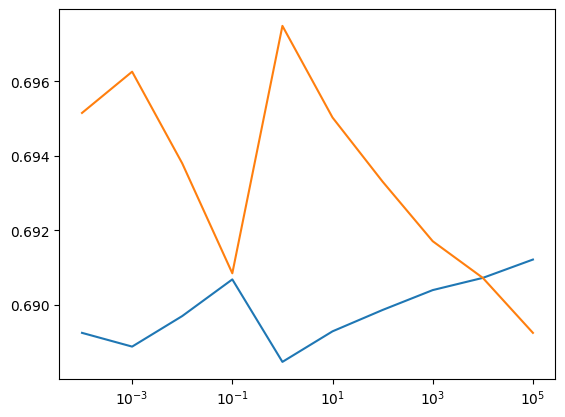

In [41]:
import matplotlib.pyplot as plt

training_scores = []
test_scores = []
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
for C in c_values:
    training_score1, test_score1 = svm_run(X, y, C=C, degree=13)
    training_score2, test_score2 = svm_run(X, y, C=C, degree=13)
    training_score3, test_score3 = svm_run(X, y, C=C, degree=13)
    training_score4, test_score4 = svm_run(X, y, C=C, degree=13)
    training_scores.append(sum([training_score1, training_score2, training_score3, training_score4]) / 4)
    test_scores.append(sum([test_score1, test_score2, test_score3, test_score4]) / 4)

plt.plot(c_values, training_scores)
plt.plot(c_values, test_scores)
plt.xscale('log')
plt.show

## Multilayer Perceptron

In [42]:
from sklearn.neural_network import MLPClassifier

def mlp_run(X, y, hidden_layer_sizes):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes)
    mlp.fit(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    training_score = mlp.score(X_train, y_train)
    test_score = mlp.score(X_test, y_test)

    return (training_score, test_score)

In [43]:
print_results(mlp_run(X, y, (10)))

Training set score: 0.67
Test set score: 0.67


In [44]:
print_results(mlp_run(X, y, (100, 100, 100)))

Training set score: 0.71
Test set score: 0.71


In [45]:
print_results(mlp_run(X, y, (100, 100, 100, 100)))

Training set score: 0.66
Test set score: 0.65


We found that the multilayer perceptron performs just as well as the support vector machine no matter and its accuracy seems to max at 71 percent or so, no matter how much power we throw at it.

With all of that in mind, and noting the corralation in the fatality count regression task with the best test results and the proportion of the datapoints that were overwhealmingly skewing results, we were curious what proportion of the category column was of the majority type. 

In [46]:
print(df['landslide_category_codes'].value_counts())

landslide_category_codes
5     5616
6     1588
10     456
0      167
2      155
8       65
14      36
9       24
11       7
13       6
1        5
4        4
3        3
Name: count, dtype: int64


In [47]:
print(5616/8132)

0.690605017215937


This is quite curious, but it makes sense. The data is so skewed, and there is so much variability in the features corresponding with the "landslide" type, that the best results come from essentially just picking "landslide" across the board. This is a bit disappointing to learn, but it is useful for us to have learned that this is a fault of heavily skewed datasets.

# Landslide Size Prediction
This one gave us more hope, because it is closer to normally distributed (see graph below), meaning we don't have a humungous skew to deal with. However, this intuition did not serve us correctly. As will be seen, we still struggle to get models that perform significantly better than taking the most common guess. We will employ all of the same techniques to this problem that we applied to the previous problems, and will thus go lighter on the commentary. 

landslide_size_codes
2    4969
1    1758
0     806
3     530
4      69
Name: count, dtype: int64


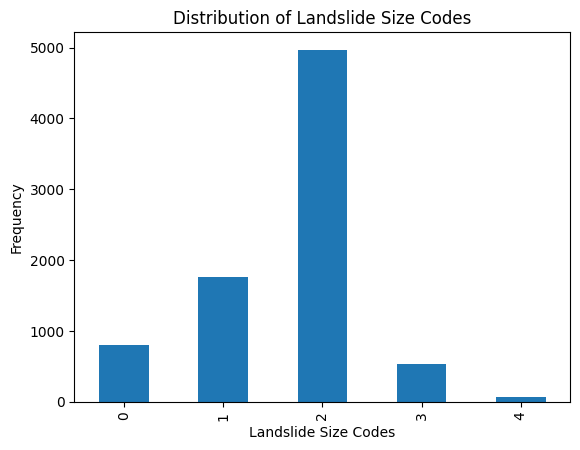

In [166]:
print(df['landslide_size_codes'].value_counts()) 

import matplotlib.pyplot as plt

df['landslide_size_codes'].value_counts().sort_index().plot(kind='bar')
plt.xlabel("Landslide Size Codes")
plt.ylabel("Frequency")
plt.title("Distribution of Landslide Size Codes")
plt.show()

In [167]:
X = df.drop(columns='landslide_size_codes')
y = df['landslide_size_codes']

## Landslide Size by Regression

Let's see if we can't get anything to happen with plain old linear regression.

In [169]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

def lr_run(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    lr.fit(X_train, y_train)
    training_score = lr.score(X_train, y_train)
    test_score = lr.score(X_test, y_test)

    return (training_score, test_score)

In [170]:
print_results(lr_run(X, y))

Training set score: 0.35
Test set score: 0.32


Not very good. Let's try with ridge regularization:

In [171]:
from sklearn.linear_model import Ridge
lrr = Ridge()

def lrr_run(X, y, a=1.0):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    lrr.fit(X_train, y_train)
    training_score = lrr.score(X_train, y_train)
    test_score = lrr.score(X_test, y_test)

    return (training_score, test_score)


In [172]:
print_results(lrr_run(X, y))
print_results(lrr_run(X, y, 0.001))
print_results(lrr_run(X, y, 10))
print_results(lrr_run(X, y, 10000))

Training set score: 0.35
Test set score: 0.32
Training set score: 0.34
Test set score: 0.35
Training set score: 0.34
Test set score: 0.36
Training set score: 0.35
Test set score: 0.32


Similarly poor for various values of *a*. Let's try a neural net.

In [173]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y)

solvers = ['lbfgs', 'adam']
hidden_layer_sizes_options = [[20], [100], [10, 10], [20, 100, 10, 10]]
activations = ['logistic', 'relu']
learning_rates = [0.001, 0.01]
alphas = [0.0001, 0.001]

for solver in solvers:
    for hidden_layers in hidden_layer_sizes_options:
        for activation in activations:
            params = {'solver': solver, 'hidden_layer_sizes': hidden_layers, 'activation': activation, 'random_state': 0}

            if solver == 'adam':
                for lr in learning_rates:
                    params['learning_rate_init'] = lr
                    mlp = MLPClassifier(**params).fit(X_train, y_train)
                    training_score = mlp.score(X_train, y_train)
                    test_score = mlp.score(X_test, y_test)
                    print(f"Solver: {solver}, Hidden Layers: {hidden_layers}, Activation: {activation}, Learning Rate: {lr} \n")
                    print_results([training_score, test_score])
            else:  # 'lbfgs' solver
                for alpha in alphas:
                    params['alpha'] = alpha
                    mlp = MLPClassifier(**params).fit(X_train, y_train)
                    training_score = mlp.score(X_train, y_train)
                    test_score = mlp.score(X_test, y_test)
                    print(f"Solver: {solver}, Hidden Layers: {hidden_layers}, Activation: {activation}, Alpha: {alpha} \n")
                    print_results([training_score, test_score])
                    

/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [20], Activation: logistic, Alpha: 0.0001 

Training set score: 0.61
Test set score: 0.61


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [20], Activation: logistic, Alpha: 0.001 

Training set score: 0.61
Test set score: 0.61
Solver: lbfgs, Hidden Layers: [20], Activation: relu, Alpha: 0.0001 

Training set score: 0.05
Test set score: 0.06
Solver: lbfgs, Hidden Layers: [20], Activation: relu, Alpha: 0.001 

Training set score: 0.05
Test set score: 0.06


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [100], Activation: logistic, Alpha: 0.0001 

Training set score: 0.61
Test set score: 0.61


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [100], Activation: logistic, Alpha: 0.001 

Training set score: 0.62
Test set score: 0.61


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [100], Activation: relu, Alpha: 0.0001 

Training set score: 0.01
Test set score: 0.01


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [100], Activation: relu, Alpha: 0.001 

Training set score: 0.01
Test set score: 0.01


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [10, 10], Activation: logistic, Alpha: 0.0001 

Training set score: 0.65
Test set score: 0.65


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [10, 10], Activation: logistic, Alpha: 0.001 

Training set score: 0.61
Test set score: 0.60
Solver: lbfgs, Hidden Layers: [10, 10], Activation: relu, Alpha: 0.0001 

Training set score: 0.10
Test set score: 0.11


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [10, 10], Activation: relu, Alpha: 0.001 

Training set score: 0.10
Test set score: 0.11


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [20, 100, 10, 10], Activation: logistic, Alpha: 0.0001 

Training set score: 0.65
Test set score: 0.64


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [20, 100, 10, 10], Activation: logistic, Alpha: 0.001 

Training set score: 0.62
Test set score: 0.61


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [20, 100, 10, 10], Activation: relu, Alpha: 0.0001 

Training set score: 0.32
Test set score: 0.32


/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Solver: lbfgs, Hidden Layers: [20, 100, 10, 10], Activation: relu, Alpha: 0.001 

Training set score: 0.32
Test set score: 0.32
Solver: adam, Hidden Layers: [20], Activation: logistic, Learning Rate: 0.001 

Training set score: 0.68
Test set score: 0.68
Solver: adam, Hidden Layers: [20], Activation: logistic, Learning Rate: 0.01 

Training set score: 0.61
Test set score: 0.61
Solver: adam, Hidden Layers: [20], Activation: relu, Learning Rate: 0.001 

Training set score: 0.62
Test set score: 0.62
Solver: adam, Hidden Layers: [20], Activation: relu, Learning Rate: 0.01 

Training set score: 0.61
Test set score: 0.61
Solver: adam, Hidden Layers: [100], Activation: logistic, Learning Rate: 0.001 

Training set score: 0.69
Test set score: 0.67
Solver: adam, Hidden Layers: [100], Activation: logistic, Learning Rate: 0.01 

Training set score: 0.63
Test set score: 0.63
Solver: adam, Hidden Layers: [100], Activation: relu, Learning Rate: 0.001 

Training set score: 0.65
Test set score: 0.65
So

This is better! Various models reach roughly 68%. We tried this with quite a few other combinations of hidden layer sizes, some quite large, and never achieved much better than 70%.

But is this very helpful? Not really! 61% of our datapoints are listed as "medium" sized landslides. These models do give us something that we know is appreciably more significant than mere guesswork (it couldn't get 68% by only guessing "medium" every time) but 68% is still not terribly helpful for trying to base anything on the results of this model. 

But, since these sizes are still categories, we can still try and do this as a classification problem.

## Landslide Size by Classification

Let's start with KNN.

In [109]:
from sklearn.neighbors import KNeighborsClassifier

def knn_run(X, y, n=3.0):

    X_train, X_test, y_train, y_test = train_test_split(X, y)
    knn = KNeighborsClassifier(n_neighbors=n)

    knn.fit(X_train, y_train)
    training_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)

    return (training_score, test_score)


In [111]:
print_results(knn_run(X, y, 1))
print_results(knn_run(X, y, 2))
print_results(knn_run(X, y, 3))
print_results(knn_run(X, y, 4))
print_results(knn_run(X, y, 5))
print_results(knn_run(X, y, 6))
print_results(knn_run(X, y, 7))
print_results(knn_run(X, y, 8))
print_results(knn_run(X, y, 9))
print_results(knn_run(X, y, 10))
print_results(knn_run(X, y, 15))
print_results(knn_run(X, y, 20))

Training set score: 1.00
Test set score: 0.60
Training set score: 0.80
Test set score: 0.57
Training set score: 0.77
Test set score: 0.61
Training set score: 0.74
Test set score: 0.62
Training set score: 0.73
Test set score: 0.60
Training set score: 0.72
Test set score: 0.60
Training set score: 0.71
Test set score: 0.64
Training set score: 0.70
Test set score: 0.63
Training set score: 0.69
Test set score: 0.64
Training set score: 0.69
Test set score: 0.64
Training set score: 0.68
Test set score: 0.64
Training set score: 0.67
Test set score: 0.65


This gets similar results to regression by the multilayer perceptron. Let's see if SVC can do better.

In [112]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

def svm_run(X, y, degree=3, C=1.0, linear=False):
    if linear:
        svm = SVC(C=C, degree=degree)
    else:
        svm = LinearSVC(C=C)
    svm.fit(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    training_score = svm.score(X_train, y_train)
    test_score = svm.score(X_test, y_test)

    return (training_score, test_score)

In [123]:
print_results(svm_run(X, y, linear=True))

Training set score: 0.61
Test set score: 0.61


In [137]:
print_results(svm_run(X, y, degree=2))

Training set score: 0.68
Test set score: 0.70


This achieves similar results. It appears that this is what is the amount of information we can generally access from this data with these models.

# Epilogue

So, at the end of the day, it turns out that this data just isn't shaped in such a way that we are able to get high levels of accuracy with the types of models we are using for the questions we were asking. However, this is not a bad thing! Instead, we learned that the fact that we have a large dataset does not mean we have one where the variables meaningfully predict each other.

# Other Fun Data Visualizations

This section contains some visualizations we discovered were quite interesting. We were able to use some of it to help us reason through the meaning and shape of our data. One fun thing to observe is how the latitude x longitude square displays the distribution of the landslides in the dataset in the world. Beyond this, the latitude and longitude crosses with other variables show how there are zones of the world with more activity. Also, we can see here that fatality is apprciably higher in Southeast Asia than in other parts of the world. Also, the day of year and minute of day variables display clustering, indicating that there are seasons that are more and less likely to have landslides.

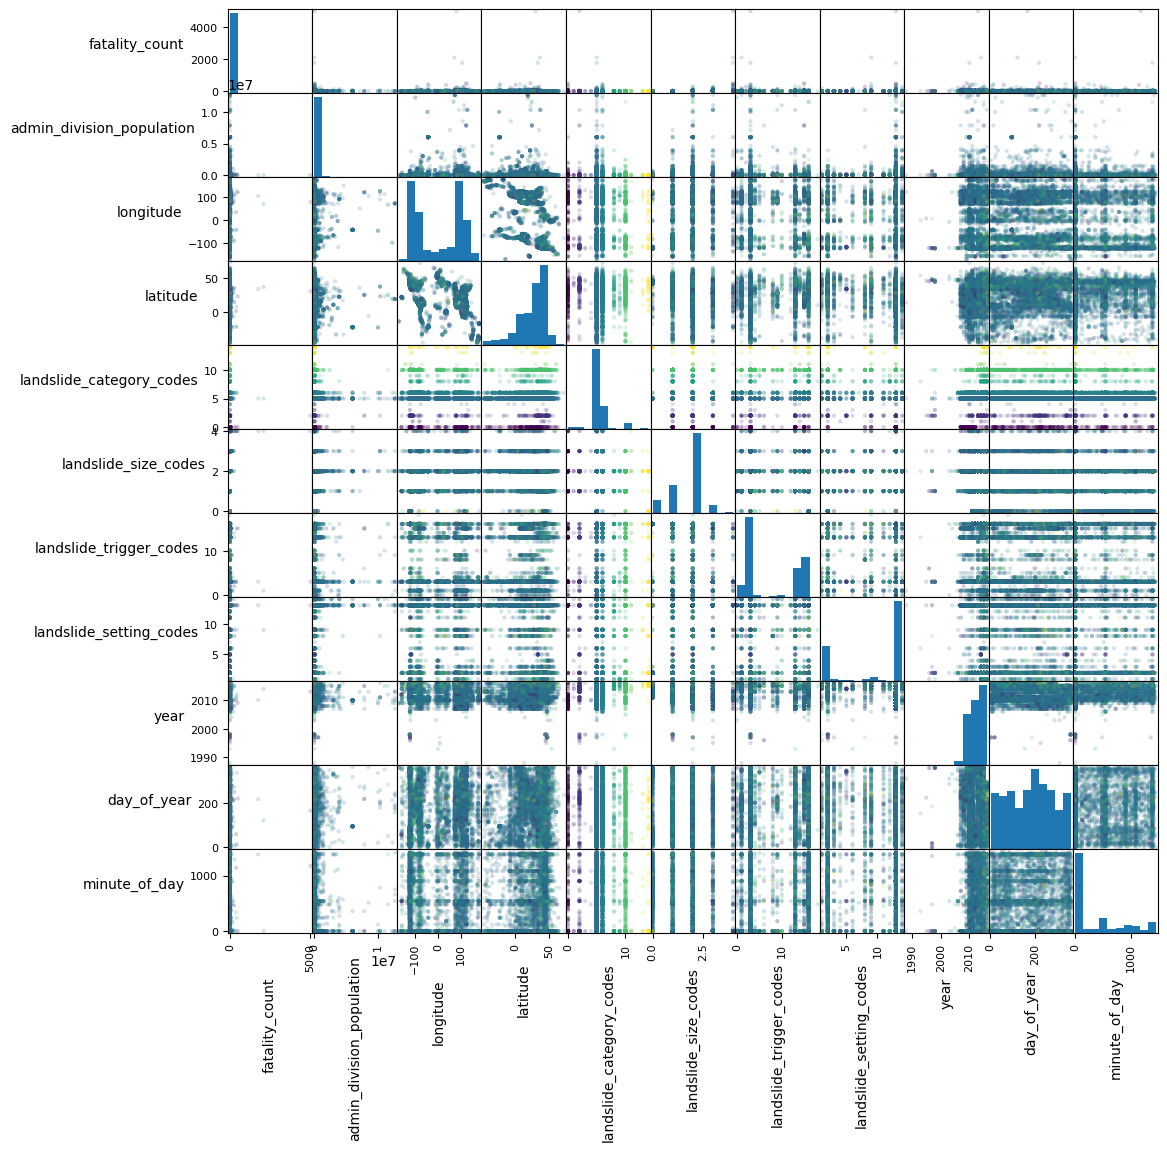

In [182]:
from pandas.plotting import scatter_matrix

smatrix = scatter_matrix(df, alpha=0.2, c=df['landslide_category_codes'], figsize=(12, 12), diagonal="hist")

# label rotation code written by Stef: https://stackoverflow.com/a/58626024
for ax in smatrix.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

/tmp/ipykernel_1836069/846117204.py:15: UserWarning: Mismatched number of handles and labels: len(handles) = 8 len(labels) = 13
  plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='landslide_category_codes')


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

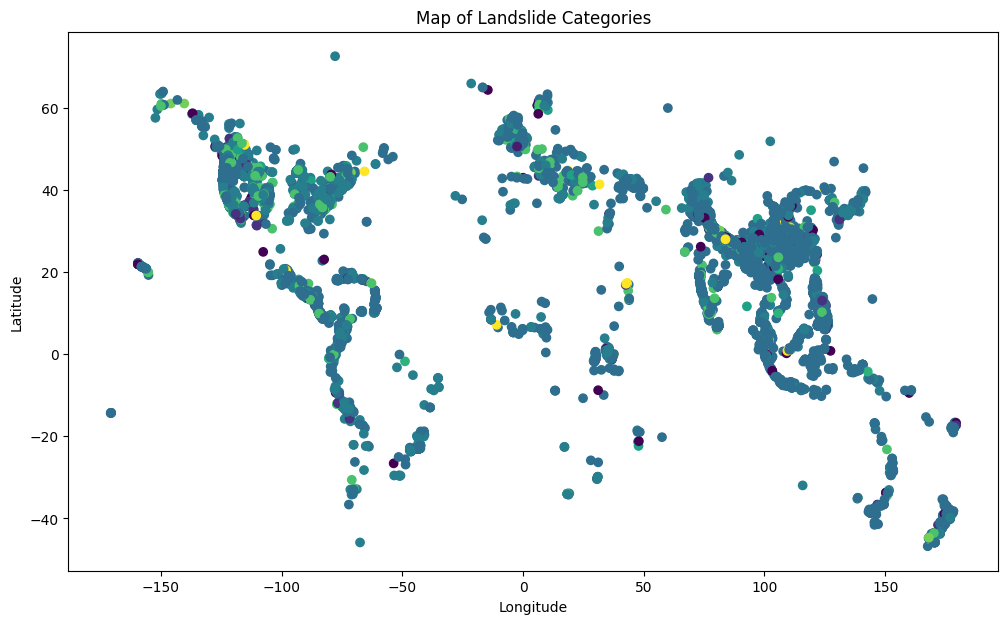

In [184]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the scatter plot, coloring points by 'col3'
plt.figure(figsize=(12, 7)) # Adjust figure size if needed
scatter = plt.scatter(df['longitude'], df['latitude'], c=df['landslide_category_codes'], cmap='viridis')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of Landslide Categories')

# Create legend
legend_labels = df['landslide_category_codes'].unique()
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='landslide_category_codes')

# Show the plot
plt.show()
plt.legend()

Here is the world topographical map: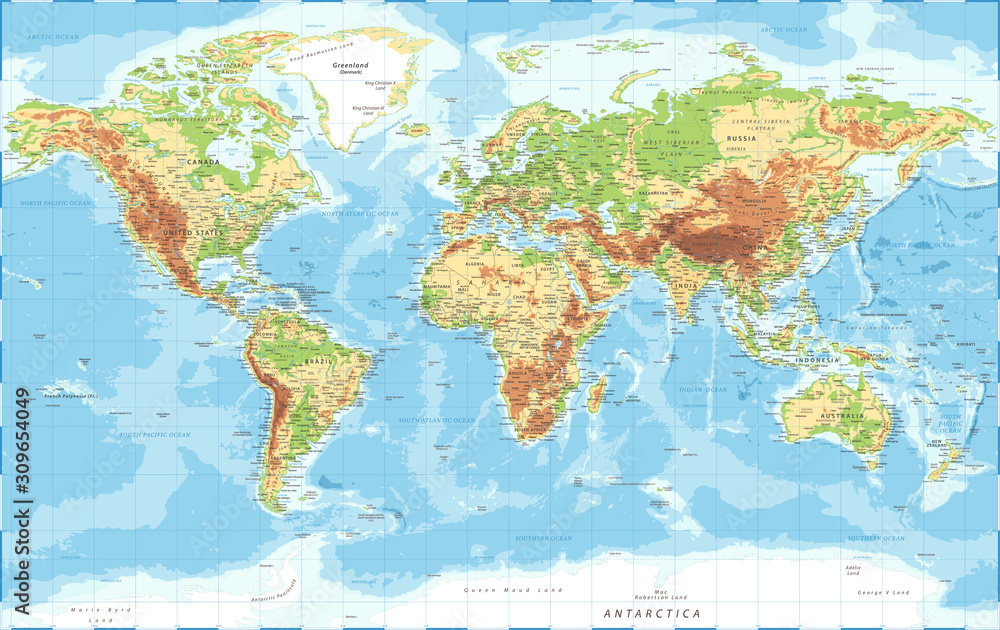 Notice how our data is somewhat clustered by mountain ranges and the equator!

### Examples of Different Categories of Landslides

earth flow:
https://www.youtube.com/shorts/bYnTXkIJaOI

